<a href="https://colab.research.google.com/github/mrromaniuc/quantum-computing/blob/main/QC_1_2_1_Squared_Distance_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum Squared-Distance Classifier

### Introduction

This is a "toy" notebook to show how to implement the algorithm explained in the Introductory chapter of the book "Supervised Learning with Quantum Computers". The algorithm is described in section 1.2.1 of the book. 

In [3]:
%%capture
#@title
#Installing qiskit standalone
!pip install imgaug==0.2.5

!pip install qiskit -U
!pip install pylatexenc

In [4]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import Aer

from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere, array_to_latex
import warnings
warnings.filterwarnings('ignore')

import numpy as np

### A brief explanation on how to setup the input for the circuit

Let's assume vector space with 2 qubits - $q_0$ and $q_1$ - where $q_0$ is the first qubit.


To apply Hadamard on the first qubit of the state vector $|q_0q_1\rangle$, we need the following operation:

H$\otimes$I = $\frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1    \end{pmatrix} $

Let's now see how the same operation looks like in qiskit, by checking the operator of the circuit:

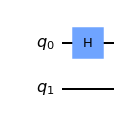

Operator([[ 1.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  1.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j, -1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [5]:
from qiskit.quantum_info.operators import Operator
qc = QuantumCircuit(2)
qc.h(0)
display(qc.draw("mpl"))

Operator(qc)/0.70710678

As can be noted, the operator above is:
$\frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1    \end{pmatrix} $ = I$\otimes$H

so, in such case, to apply Hadamard in the qubit $q_0$ we need to invert the order of the qubits in the vector, having:

I$\otimes$H$|q_1q_0\rangle$

To conclude, to use the original vector space provided by the sample in the book, in qiskit the input qubits must be swaped before applying Hadamard. 

### Setting up the original vector and visualizing the amplitudes

In [6]:
#Original State Vector
sv = np.array([0, 0.921, 0, 0.39, 0.141, 0, 0.99, 0, 0, 0.866, 0, 0.5, 0.866, 0, 0.5, 0])
sv_norm = sv/np.linalg.norm(sv)
print(sv_norm)

[0.         0.46048653 0.         0.1949943  0.07049794 0.
 0.49498552 0.         0.         0.43298734 0.         0.24999269
 0.43298734 0.         0.24999269 0.        ]


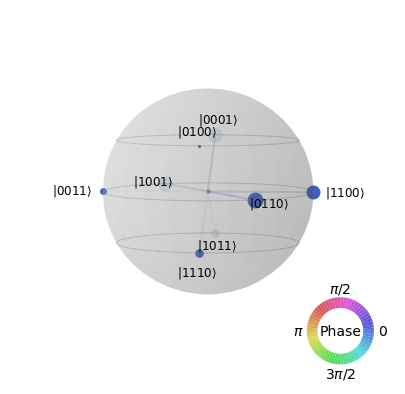

In [7]:
# |q1q2q3q4>
# Showing the amplitudes in the qsphere...
# q1=0 Sample Data; q1=1  Target Data
# q2=0 Passenger1; q2=1 Passenger2
# q3=0 price feat; q3=1 room feat
# q4=0 died; q4=1 survived
  
plot_state_qsphere(sv_norm)

### The circuit

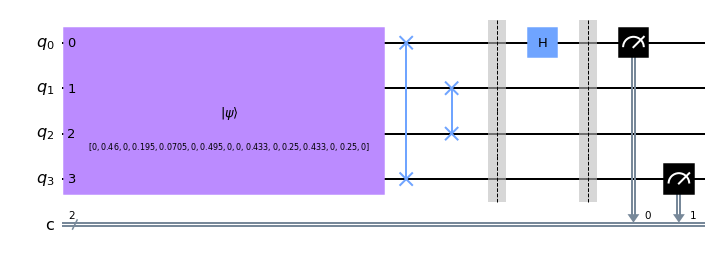

In [8]:
qc = QuantumCircuit(4,2)

#Initialize inverting the order of qubits... as operator in Qiskit is given by np.kron(I, H) and book uses np.kron(H, I) 
qc.initialize(sv_norm, [0,1,2,3])
qc.swap(0,3)
qc.swap(1,2)
qc.barrier()

qc.h(0)

qc.save_statevector()
qc.measure(0,0)
qc.measure(3,1)

qc.draw("mpl")

### Running the circuit and calculating dead and alive percentages

In [21]:
sim = Aer.get_backend('aer_simulator')
  
job = sim.run(qc, shots=1000000)
result = job.result()
#sv = result.get_statevector()

print(result.get_counts())
#display(array_to_latex(sv, prefix="\\text{Before Meas.   = }", max_size=20))

{'11': 1952, '01': 96105, '10': 497842, '00': 404101}


In [22]:
# |q4q1>
# Only use the basis where q1=0 (according to algo) - discard the other amplitudes
# q4=0 means prob. of dead
# q4=1 means prob. of alive
counts=result.get_counts()
deadNum   = counts['00']
aliveNum  = counts['10']

deadPct = deadNum/(deadNum+aliveNum)
alivePct = aliveNum/(deadNum+aliveNum)

print(f"deadPct = {deadPct}")
print(f"alivePct = {alivePct}")

deadPct = 0.44803385579798277
alivePct = 0.5519661442020172
